### Business Problem
Customer churn occurs when customers or subscribers stop doing business with a company or service, also known as customer attrition. It is also referred as loss of clients or customers. One industry in which churn rates are particularly useful is the telecommunications industry, because most customers have multiple options from which to choose within a geographic location. Here we ned to predict the probability that the customer retains with the company.

In [42]:
import pandas as pd
import mlflow
import seaborn as sns
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

#seaborn styling
plt.style.use('seaborn-whitegrid')
sns.set(font_scale = 3)

In [43]:
df = pd.read_csv('../data/data.csv')
print(df.shape)
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### About Dataset

This dataset contains `7043` observations and `21` features and 1 label (`Churn`)

| __Feature Name__ | __Description__ | __Data Type__ |
| - | - | - |
| customerID | Contains customer ID | categorical | 
| gender | whether the customer female or male | categorical |
| SeniorCitizen | Whether the customer is a senior citizen or not (1, 0) | numeric, int |
| Partner | Whether the customer has a partner or not (Yes, No) | categorical |
| Dependents | Whether the customer has dependents or not (Yes, No) | categorical | 
| tenure | Number of months the customer has stayed with the company | numeric, int |
| PhoneService | Whether the customer has a phone service or not (Yes, No) | categorical |
| MultipleLines | Whether the customer has multiple lines r not (Yes, No, No phone service) | categorical |
| InternetService | Customer’s internet service provider (DSL, Fiber optic, No) | categorical |
| OnlineSecurity | Whether the customer has online security or not (Yes, No, No internet service) | categorical | 
| OnlineBackup |  Whether the customer has online backup or not (Yes, No, No internet service) | categorical | 
| DeviceProtection | Whether the customer has device protection or not (Yes, No, No internet service) | categorical |
| TechSupport | Whether the customer has tech support or not (Yes, No, No internet service) | categorical | 
| streamingTV | Whether the customer has streaming TV or not (Yes, No, No internet service) | categorical |
| streamingMovies | Whether the customer has streaming movies or not (Yes, No, No internet service) | categorical |
| Contract | The contract term of the customer (Month-to-month, One year, Two year) | categorical |
| PaperlessBilling | Whether the customer has paperless billing or not (Yes, No) | categorical |
| PaymentMethod | The customer’s payment method (Electronic check, Mailed check, Bank transfer, Credit card) | categorical |
| MonthlyCharges | The amount charged to the customer monthly  |  numeric , int |
| TotalCharges | The total amount charged to the customer  | object |
| Churn | Whether the customer churned or not (Yes or No) | categorical |

### train test split

In [44]:
from sklearn.model_selection import train_test_split

def load_and_split(data_path ='data/winequality-red.csv'):
    try:
        data = pd.read_csv(data_path)
        X = data.drop(["Churn"], axis=1)
        y = data['Churn']
        X_train,X_test,y_train, y_test =  train_test_split(X,y,test_size=0.25,random_state=42)
        df_train = pd.concat([X_train,y_train],axis=1)
        df_test = pd.concat([X_test,y_test],axis=1) 
        return df_train,df_test

    except Exception as e:
        print(f'Unable to load data.:{e}')
        raise e


df_train,df_test = load_and_split('../data/data.csv')
df_train.shape,df_test.shape

((5282, 21), (1761, 21))

### Basic Analysis

In [45]:
# checking datatype
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 6607 to 860
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5282 non-null   object 
 1   gender            5282 non-null   object 
 2   SeniorCitizen     5282 non-null   int64  
 3   Partner           5282 non-null   object 
 4   Dependents        5282 non-null   object 
 5   tenure            5282 non-null   int64  
 6   PhoneService      5282 non-null   object 
 7   MultipleLines     5282 non-null   object 
 8   InternetService   5282 non-null   object 
 9   OnlineSecurity    5282 non-null   object 
 10  OnlineBackup      5282 non-null   object 
 11  DeviceProtection  5282 non-null   object 
 12  TechSupport       5282 non-null   object 
 13  StreamingTV       5282 non-null   object 
 14  StreamingMovies   5282 non-null   object 
 15  Contract          5282 non-null   object 
 16  PaperlessBilling  5282 non-null   object

In [46]:
# checking null values
# checking for missing values

def top_missing_cols(df,n=10,thresh=80):
    """
    returns missing columns in dataframe with missing values percent > thresh
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """
    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff
    
top_missing_cols(df_train)


There are 0 columns in this dataset with missing values.
There are 0 columns with missing percent values than 80%


,col,missing_percent
0,customerID,0.0
1,DeviceProtection,0.0
2,TotalCharges,0.0
3,MonthlyCharges,0.0
4,PaymentMethod,0.0
5,PaperlessBilling,0.0
6,Contract,0.0
7,StreamingMovies,0.0
8,StreamingTV,0.0
9,TechSupport,0.0


In [47]:

# checking for duplicates
df_train[df_train.duplicated()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


* We have no missing values and duplicates. Let us proceed further

In [73]:
#helper functions
def plot_numeric_target_map(col_name,target_col,figsize=(25,12),
                            apply_log=False,df_train=df_train):


    dff_ = df_train[df_train[target_col] == 1].copy()
    dff_not = df_train[df_train[target_col] == 0].copy()
    
    
    
    if apply_log:
        dff_['log_'+col_name] = np.log(dff_[col_name])
        dff_not['log_'+col_name] = np.log(dff_not[col_name])
        col_name = 'log_'+col_name
        
    fig,axes = plt.subplots(1,2,figsize=figsize)
    sns.distplot(dff_not[col_name],ax=axes[0],label='Retained customers')
    sns.distplot(dff_[col_name],ax=axes[0],label='Churned customers')
    axes[0].title.set_text(f'{col_name} distribution Train')
    axes[0].legend()
    sns.boxplot(df_train[col_name],ax=axes[1])
    axes[1].title.set_text(f'{col_name} Distribution')
    plt.show()
    del dff_,dff_not



def plot_categoric_target_map(col,target_col,df=df_train,figsize=(25,12),rotation=90):
    """
    plot bar graph
    """
    
    tmp = df[[target_col,col]]
    tmp1 = tmp[col].value_counts().reset_index().rename(columns={'index':col,col:'Count'})
    tmp2 = tmp.groupby(by=col).mean().reset_index()
#     tmp3 = tmp[tmp[target_col] == 1][col].value_counts().reset_index().rename(columns={'index':col, col:'Count'})
#     tmp4 = tmp[tmp[target_col] == 0][col].value_counts().reset_index().rename(columns={'index':col, col:'Count'})

    f, axes = plt.subplots(1,2,figsize=figsize)
    g = sns.barplot(y=tmp1['Count'],x=tmp1[col],ax=axes[0])
    g.set_xticklabels(g.get_xticklabels(), rotation=rotation)
    axes[0].title.set_text(f'Total count of various {col} types')
      
    g = sns.barplot(x=tmp2[col],y=tmp2[target_col],ax=axes[1])
    g.set_xticklabels(g.get_xticklabels(), rotation=rotation)
    axes[1].title.set_text(f"Percentage of cutomers who left among various {col} types")
    
   
    plt.tight_layout()
    plt.show()

#### In Depth EDA



**Churn**

Churn is the opposite of retention. Churn = Yes means customer has left the company.Churn = No means the customers which are retained.

In [50]:
df_train["Churn"].value_counts()

No     3892
Yes    1390
Name: Churn, dtype: int64

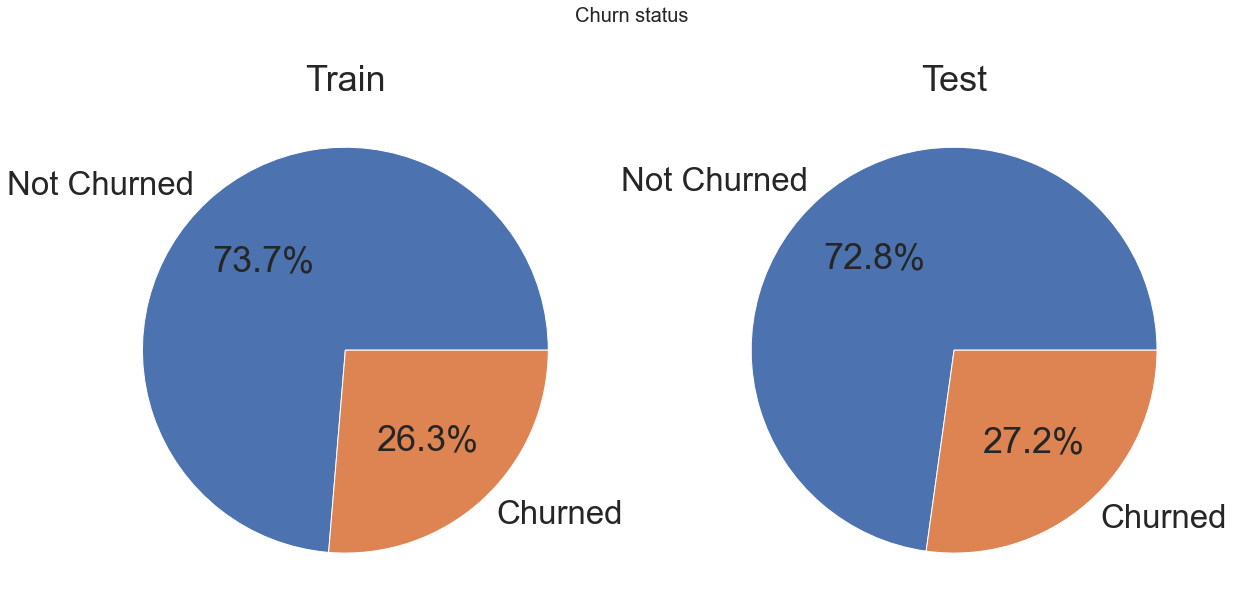

In [51]:
tmp_train = df_train["Churn"].map({"Yes":1,"No":0}).value_counts()
tmp_test = df_test["Churn"].map({"Yes":1,"No":0}).value_counts()
fig, ax = plt.subplots(1,2,figsize=[20,10])
ax[0].pie(tmp_train,labels =['Not Churned','Churned'],autopct="%.1f%%");
ax[0].set_title('Train')
# ax[1].pie(tmp_cv,labels =['Fully Paid ','Charged Off'],autopct="%.1f%%");
# ax[1].set_title('CV')
ax[1].pie(tmp_test,labels =['Not Churned','Churned'],autopct="%.1f%%");
ax[1].set_title('Test')
plt.suptitle("Churn status", fontsize=20);

In [52]:
df_train["Churn"] = df_train["Churn"].map({"Yes":1,"No":0})
df_test["Churn"] = df_test["Churn"].map({"Yes":1,"No":0})

**Customer id**

- There will be a unique id for each customer

In [53]:
df_train['customerID'].unique()

array(['7242-QZLXF', '8325-QRPZR', '7874-ECPQJ', ..., '8044-BGWPI',
       '7450-NWRTR', '4795-UXVCJ'], dtype=object)

**gender**

In [54]:
df_train['gender'].value_counts()

Male      2713
Female    2569
Name: gender, dtype: int64

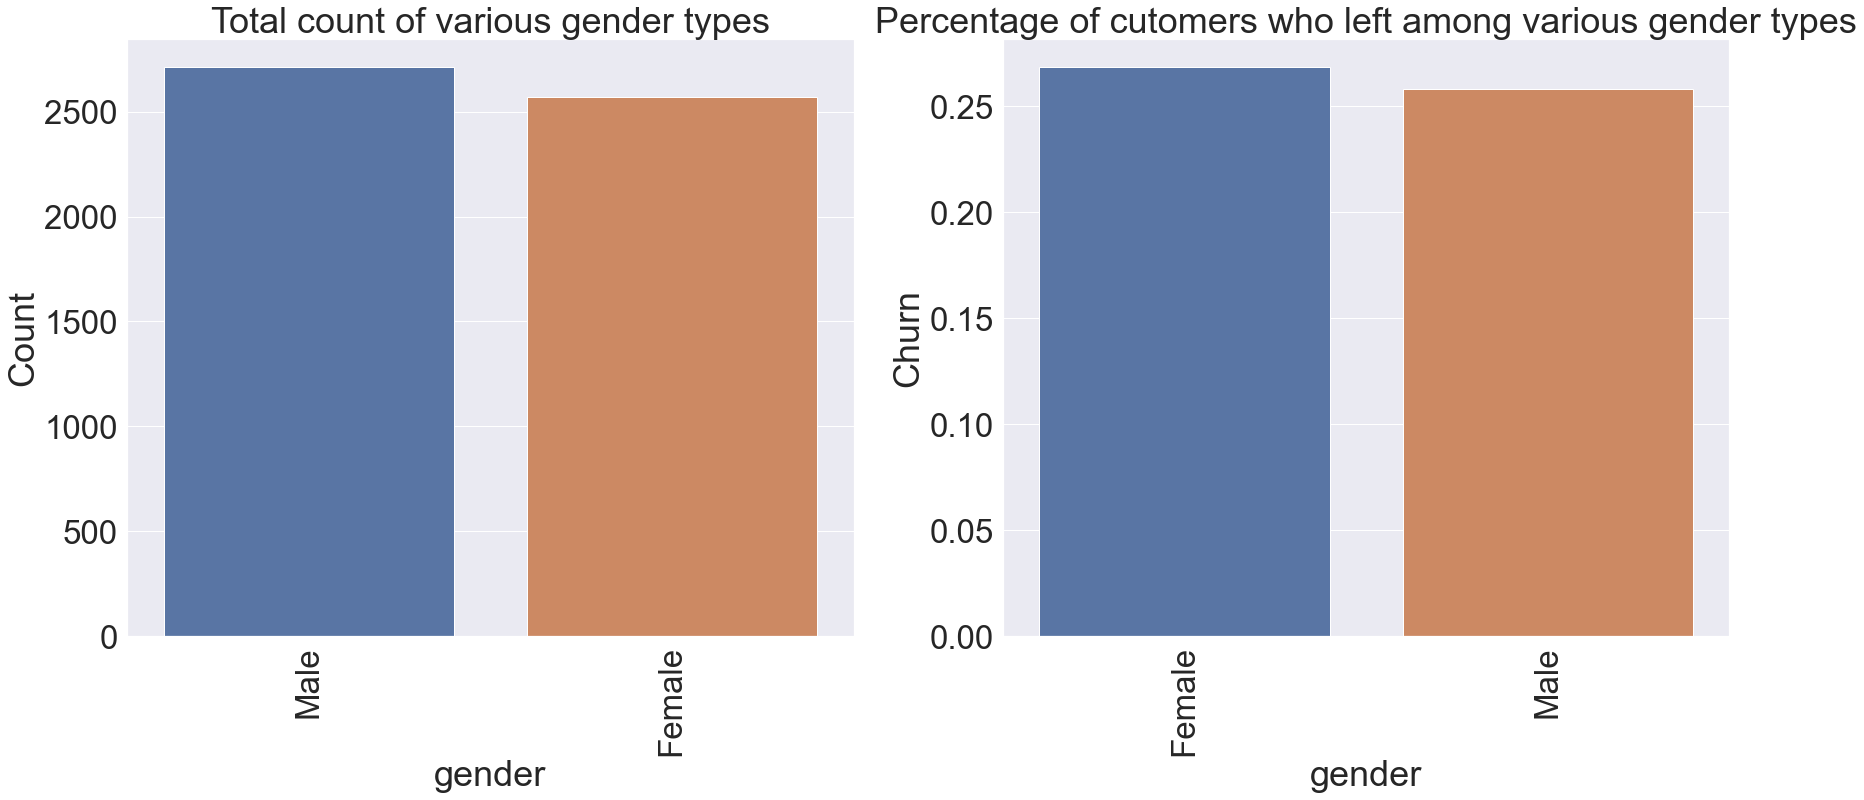

In [55]:
plot_categoric_target_map(col="gender",target_col="Churn")

**SeniorCitizen**

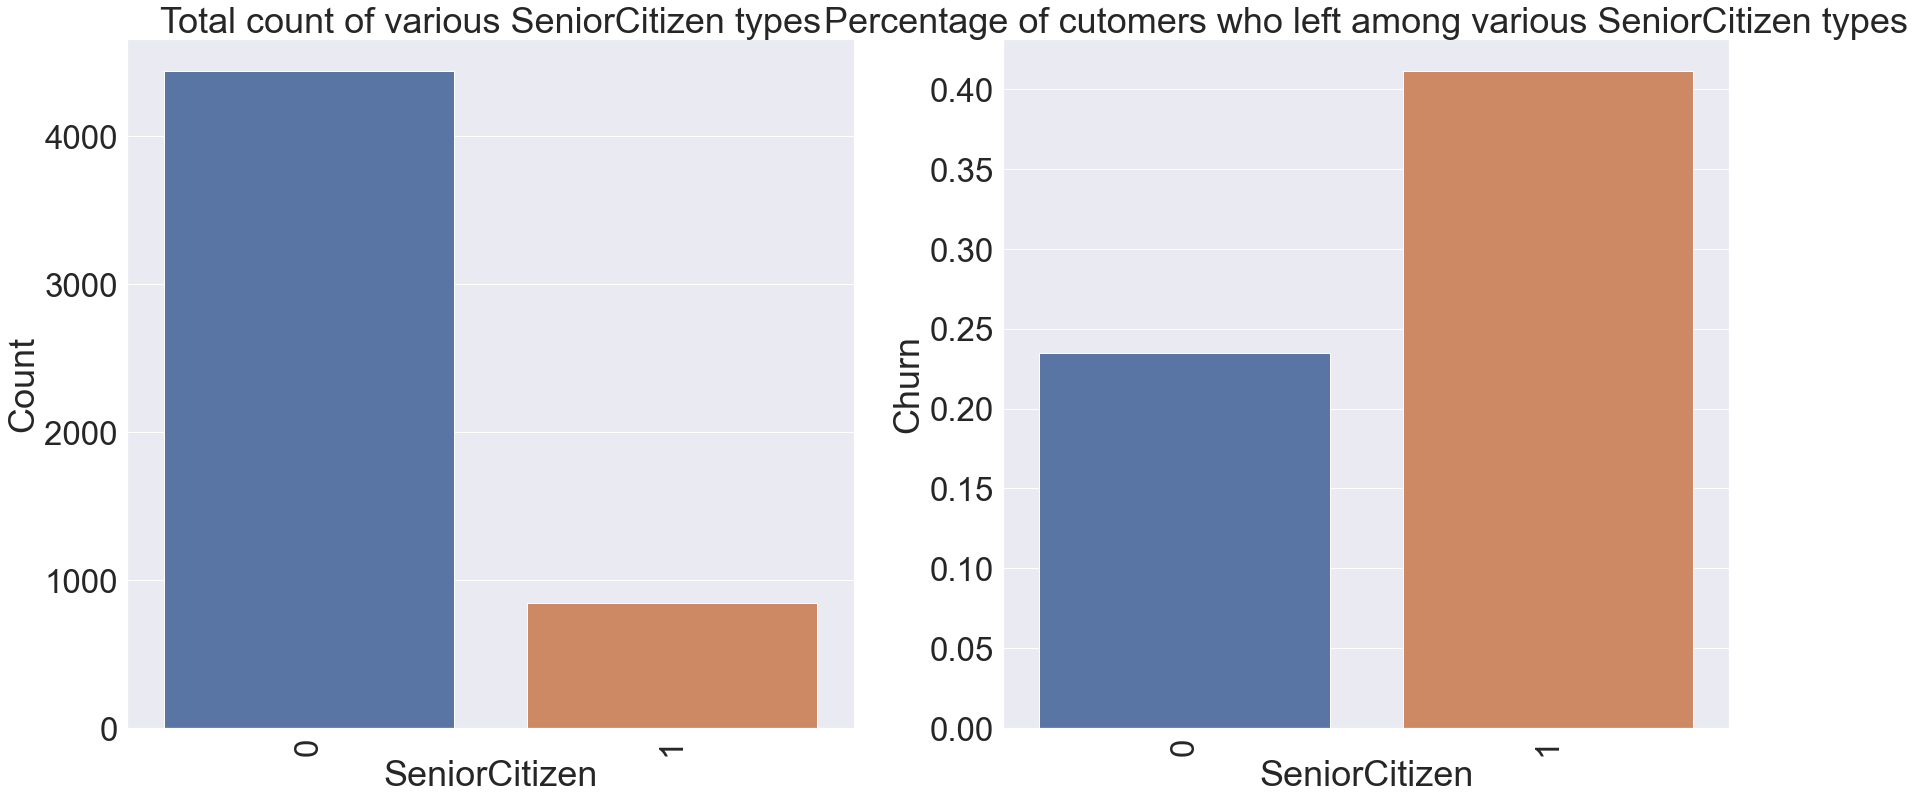

In [56]:
plot_categoric_target_map(col="SeniorCitizen",target_col="Churn")

We can see that Churn rate is high amoung senior citizens(about 40%).Also its int type, we will convert it to categorical.

In [57]:
df_train["SeniorCitizen"] = df_train["SeniorCitizen"].map({1:"senior",0:"non senior"})
df_test["SeniorCitizen"] = df_test["SeniorCitizen"].map({1:"senior",0:"non senior"})

**Partner**

Wheather the customer has partner or not.

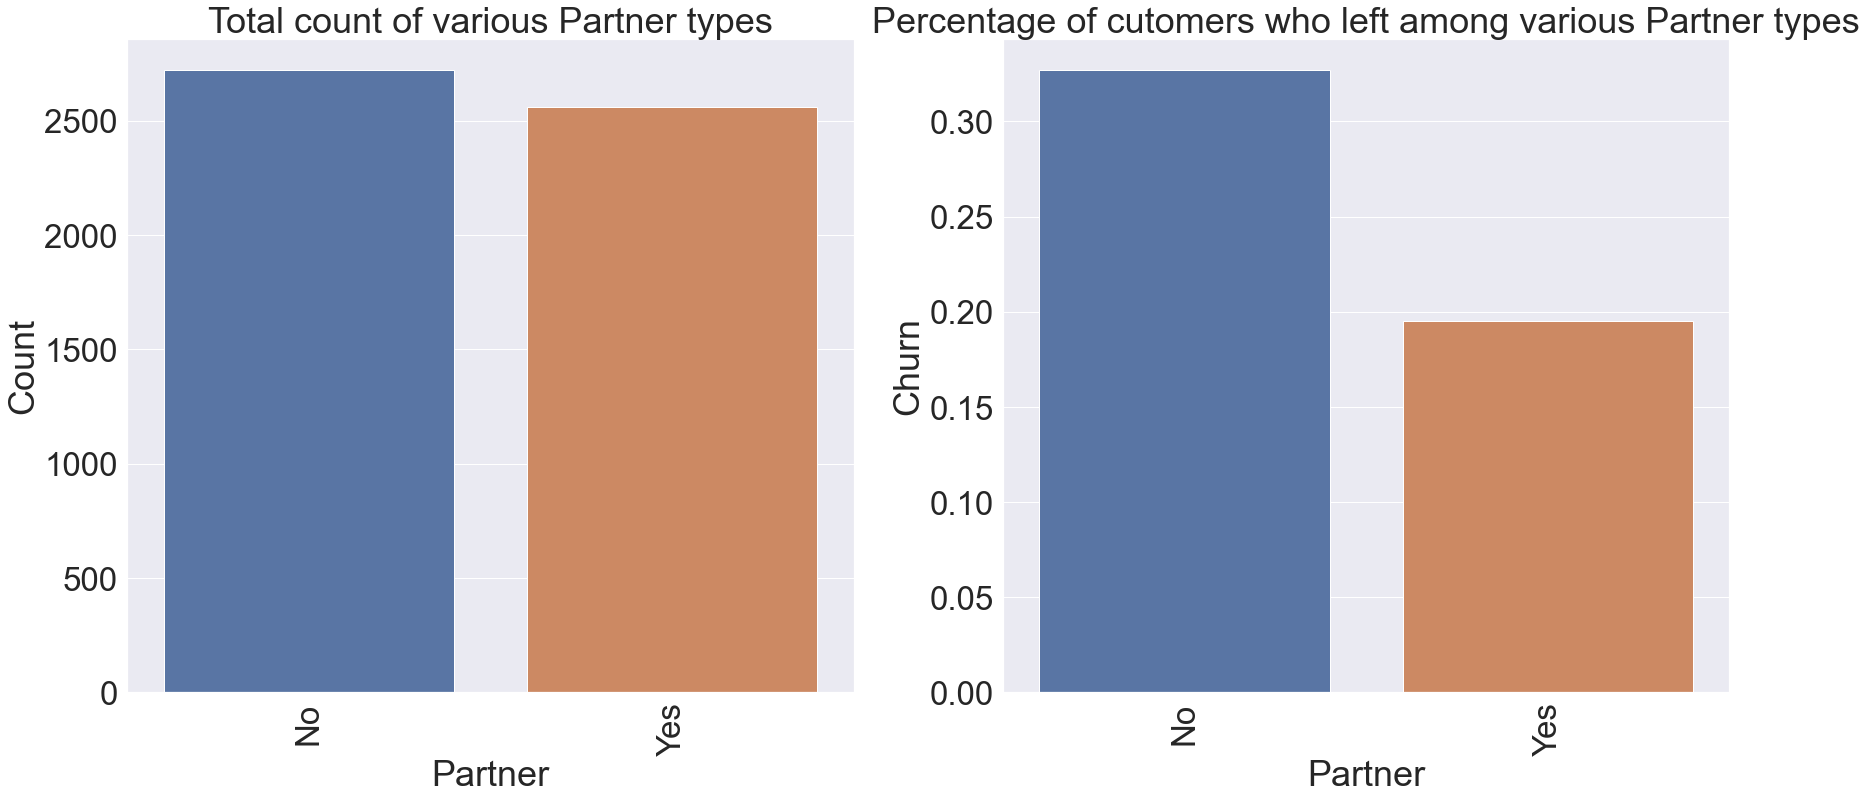

In [58]:
plot_categoric_target_map(col="Partner",target_col="Churn")

**Dependents**

Wheather the customer has dependents or not.

In [59]:
df_train["Dependents"].value_counts()

No     3696
Yes    1586
Name: Dependents, dtype: int64

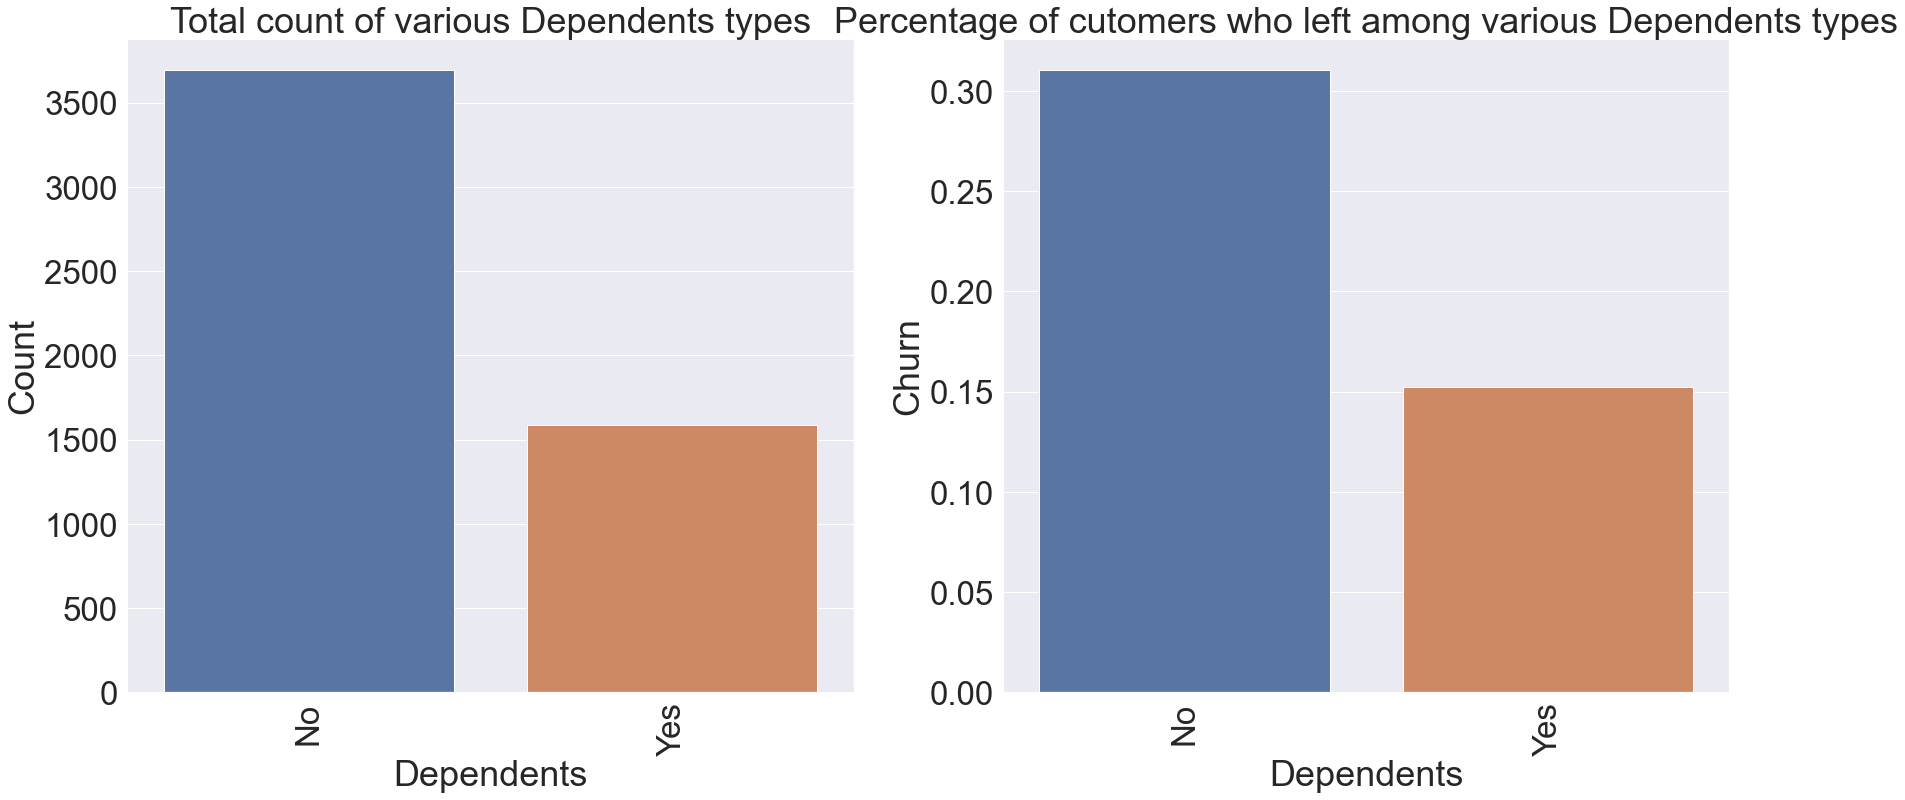

In [60]:
plot_categoric_target_map(col="Dependents",target_col="Churn")

**Tenure**

Number of months the customer has stayed with company

In [61]:
df_train['tenure'].describe()

count    5282.000000
mean       32.414237
std        24.489554
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

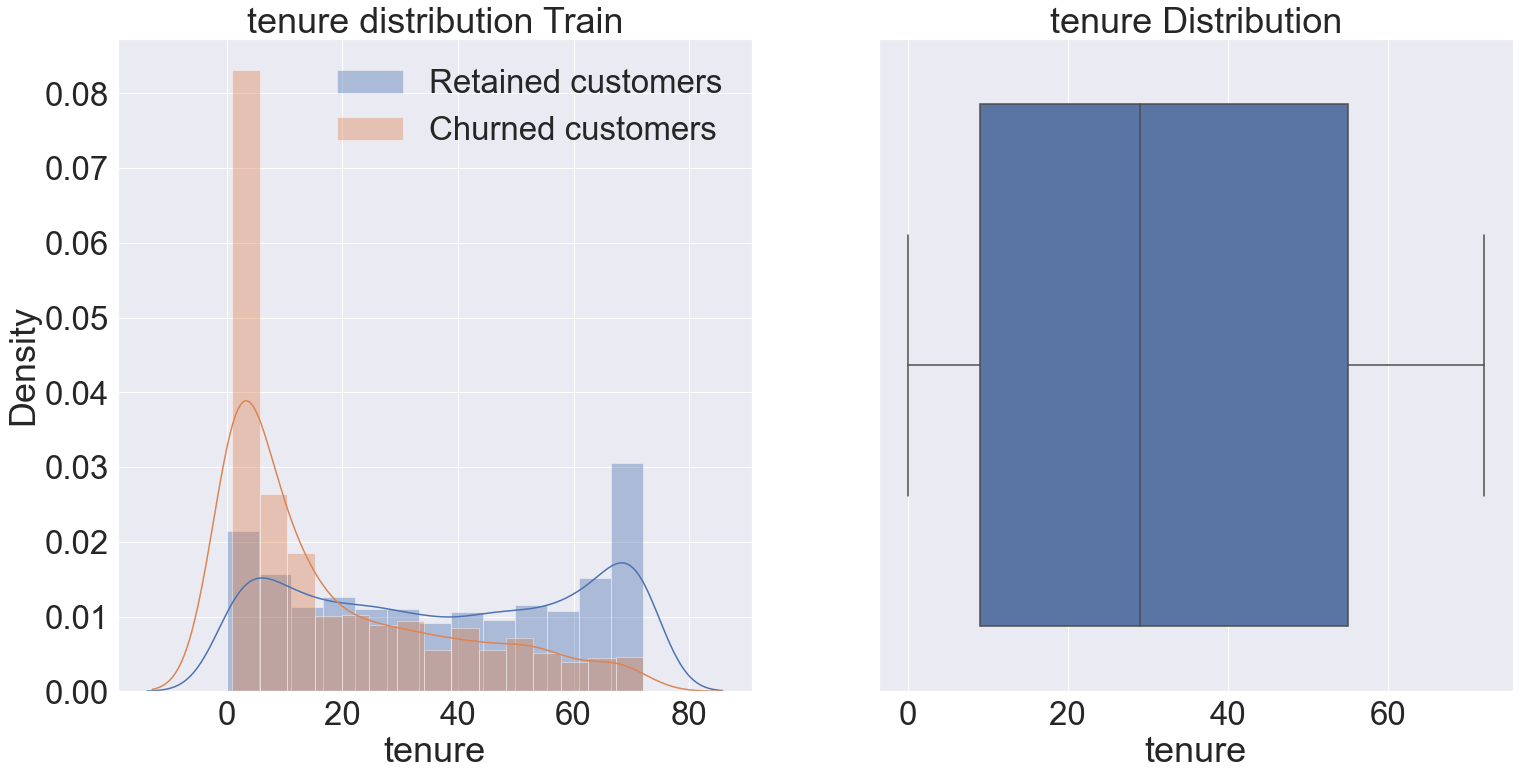

In [74]:
plot_numeric_target_map(col_name="tenure",target_col="Churn")

We can see that when tenure is greater than 40 years, there is more chance hat the customer is retained.

**Phone service, MultipleLines and Internet service**

* Phone service means wheather the customer has phone service or not
* Multiple lines means wheather the customer has multiple lines of service or not.
* Internet service means type of internet service the cutomer have

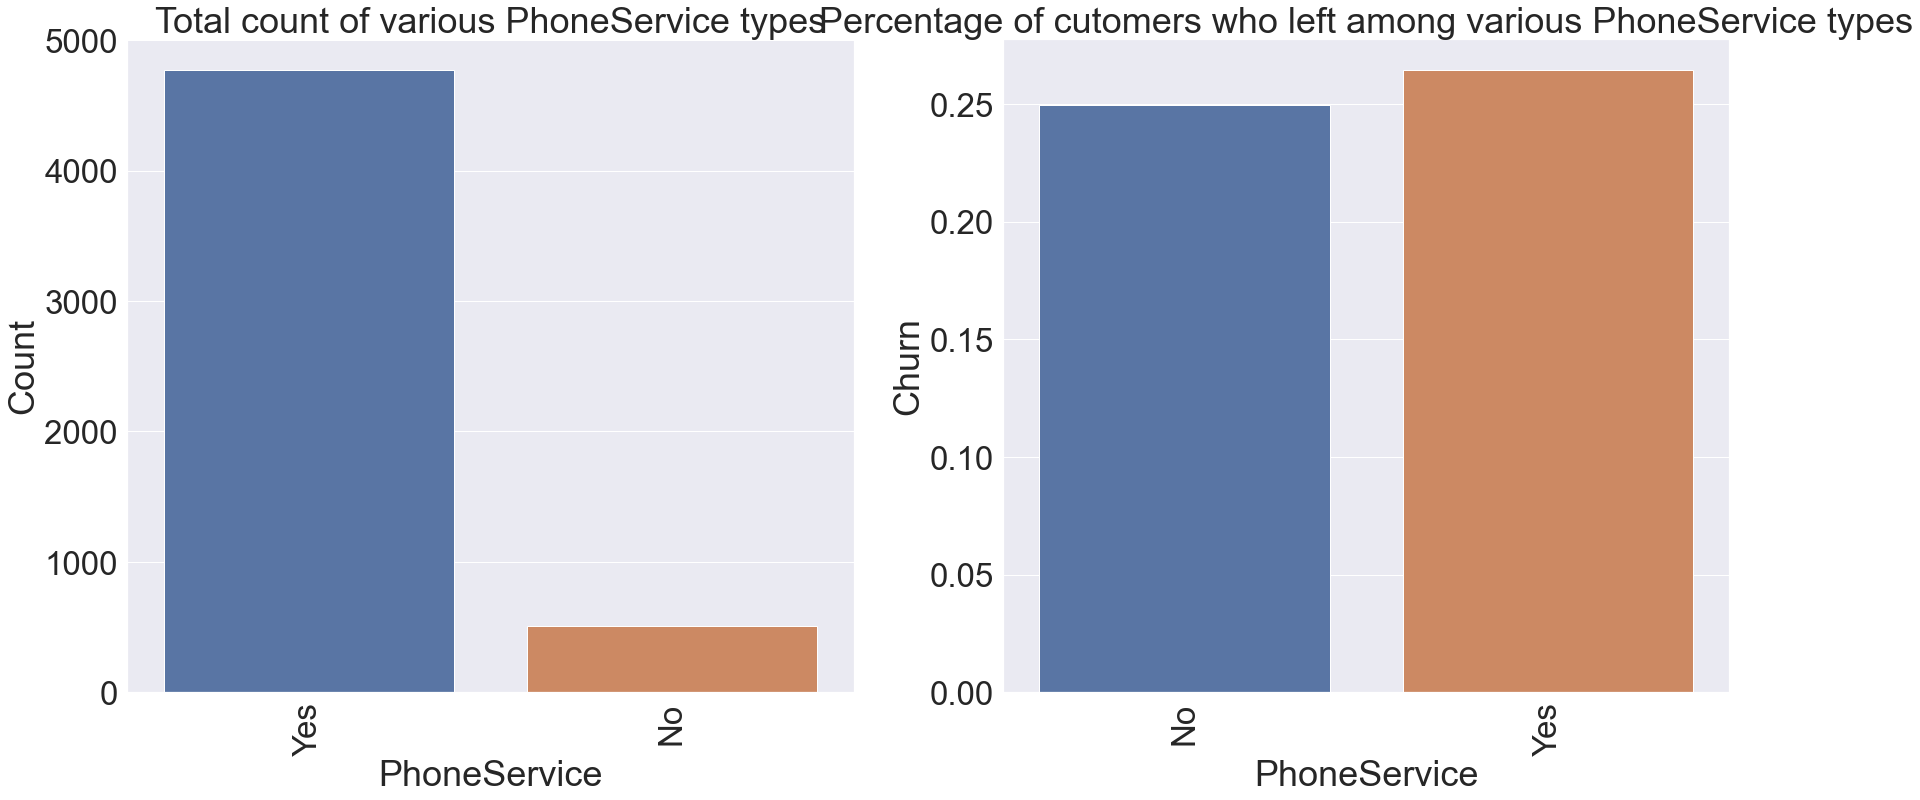

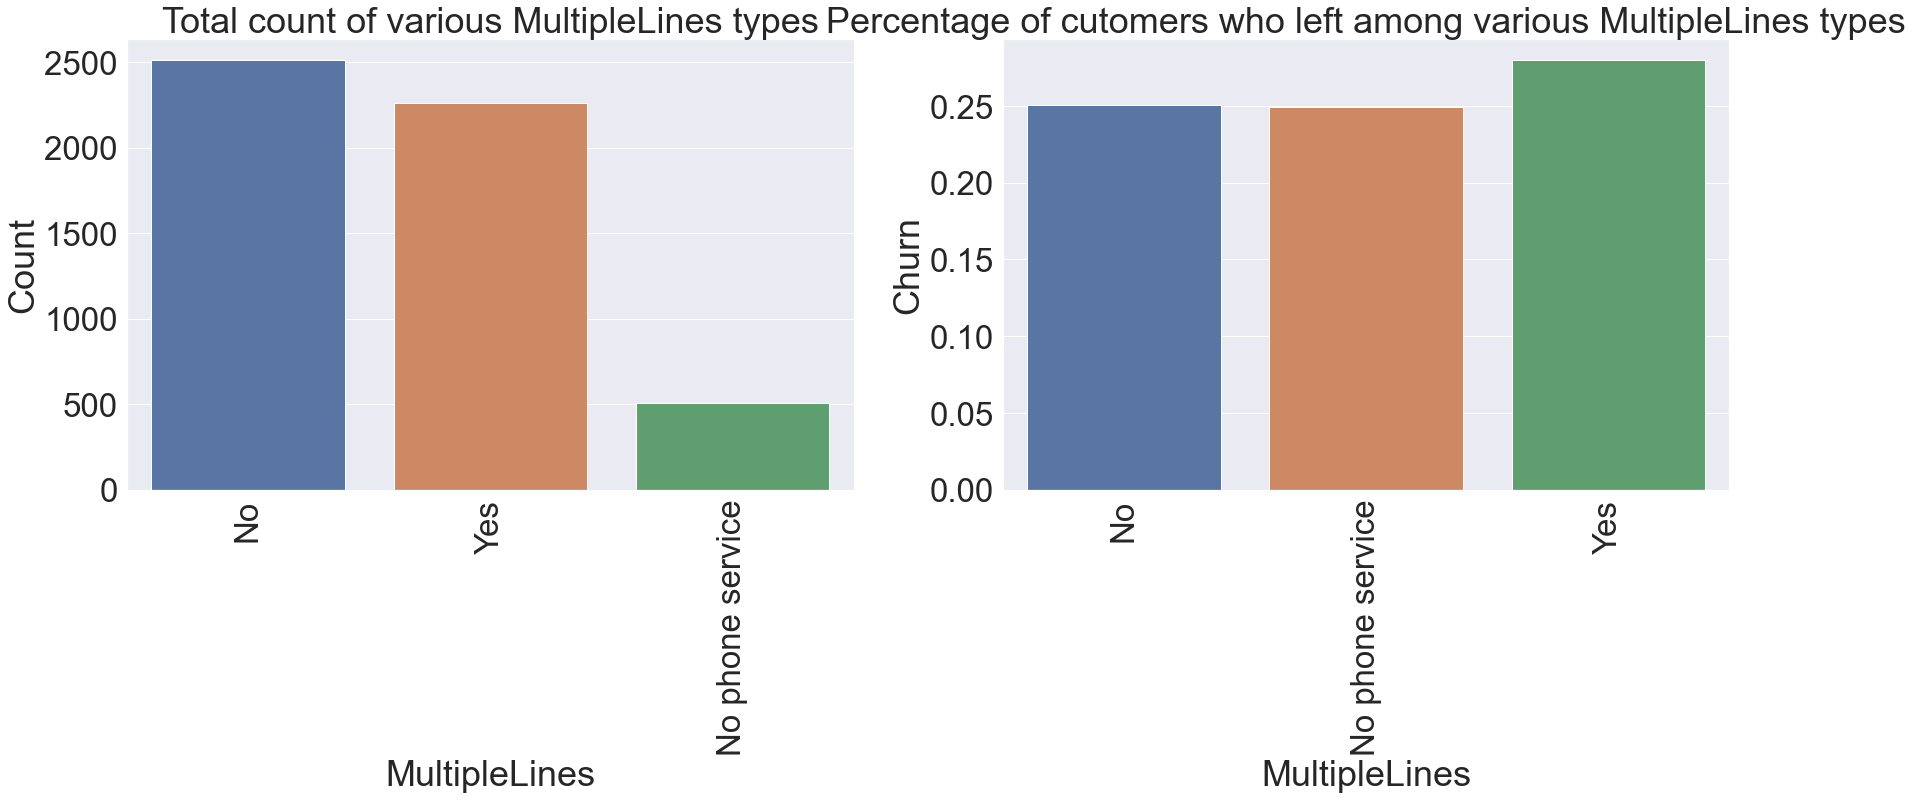

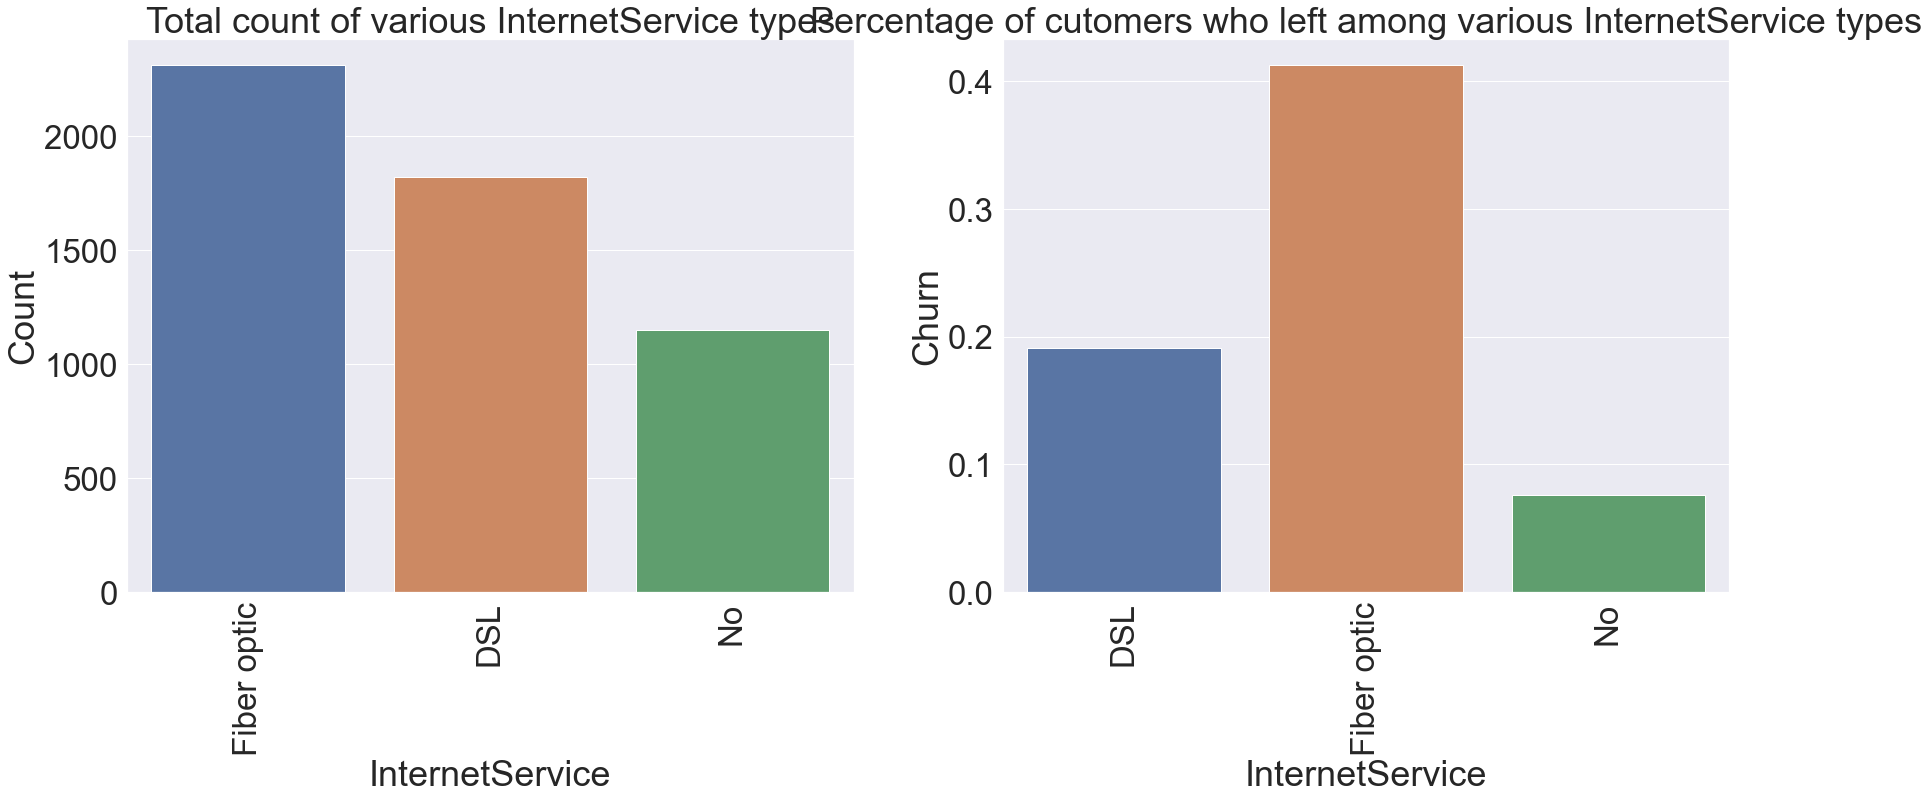

In [75]:
plot_categoric_target_map(col="PhoneService",target_col="Churn")
plot_categoric_target_map(col="MultipleLines",target_col="Churn")
plot_categoric_target_map(col="InternetService",target_col="Churn")

We can create another column for internet service.

In [79]:
df_train["InternetService_flag"] = df_train["InternetService"].apply(lambda x: "Yes" if x != "No" else "No")
df_test["InternetService_flag"] = df_test["InternetService"].apply(lambda x: "Yes" if x != "No" else "No")


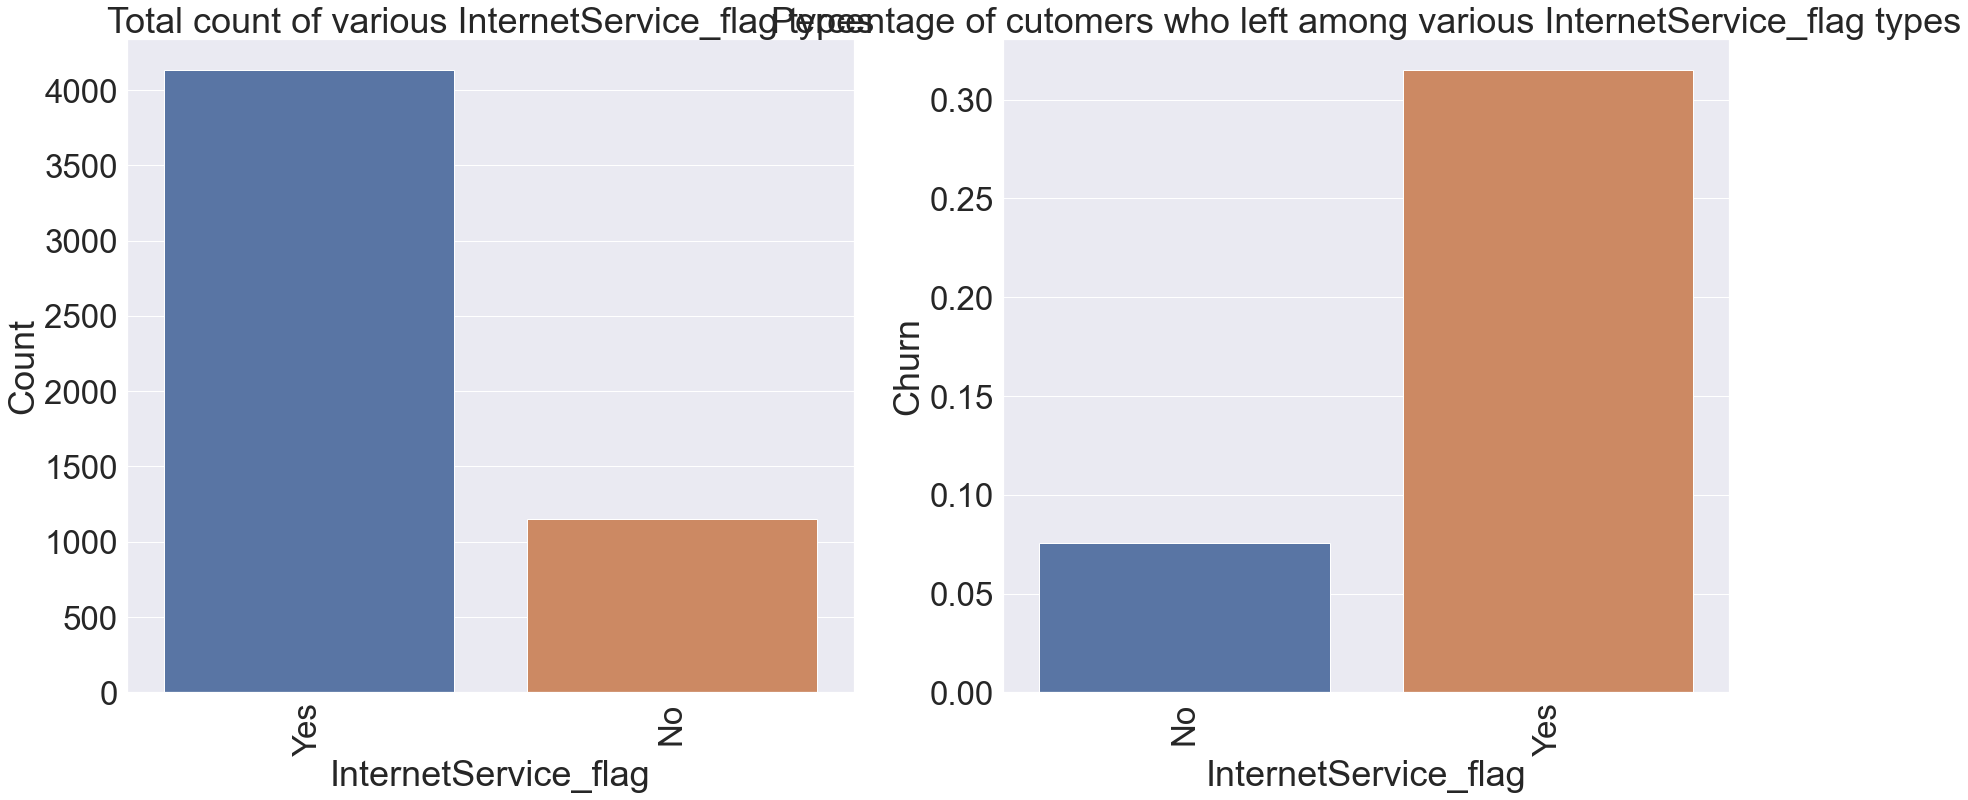

In [80]:
plot_categoric_target_map(col="InternetService_flag",target_col="Churn")

OnlineSecurity, Onlinebackup, Device Protection

* Online backup - whather customer has online backup or not
* OnlineSecurity - heathe customer has online security or not.


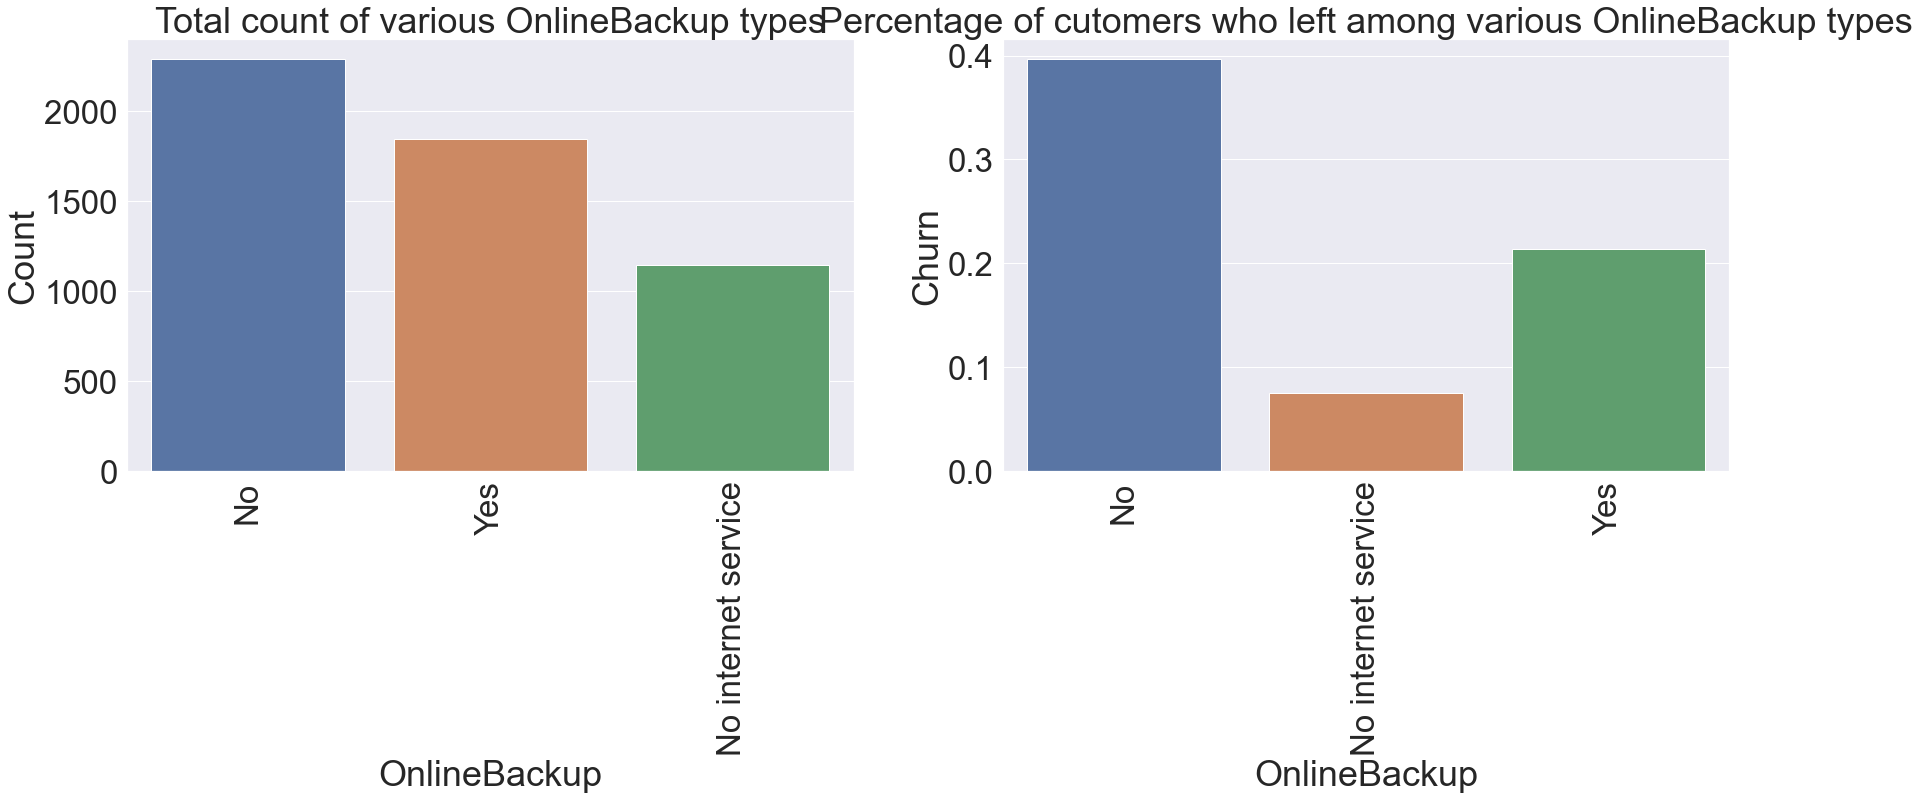

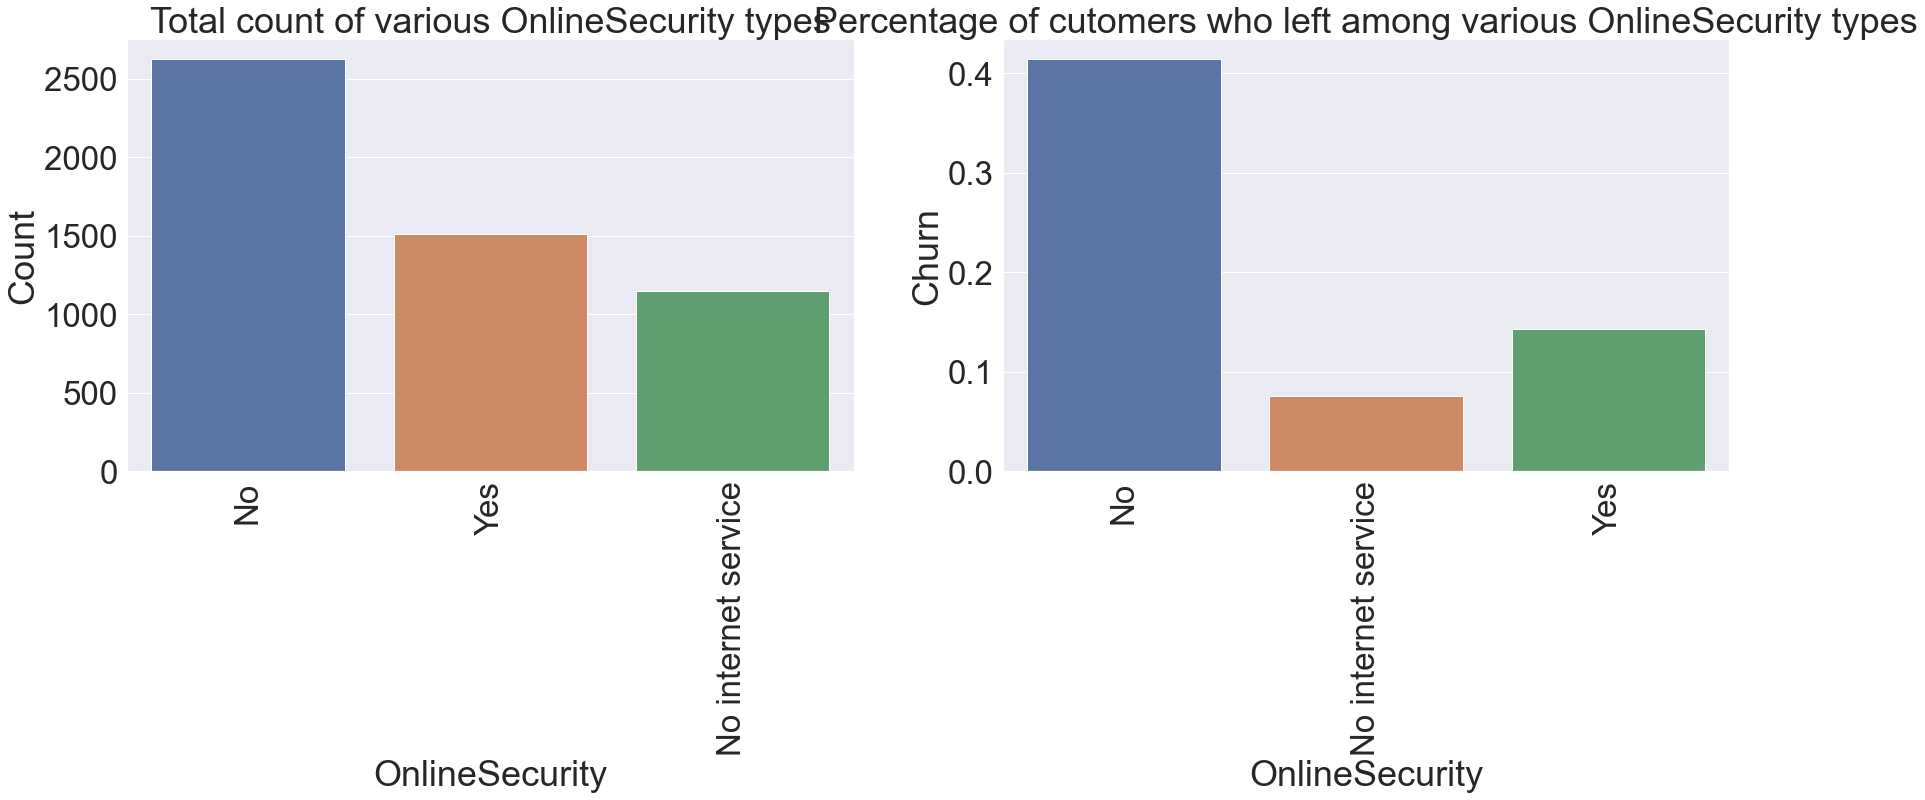

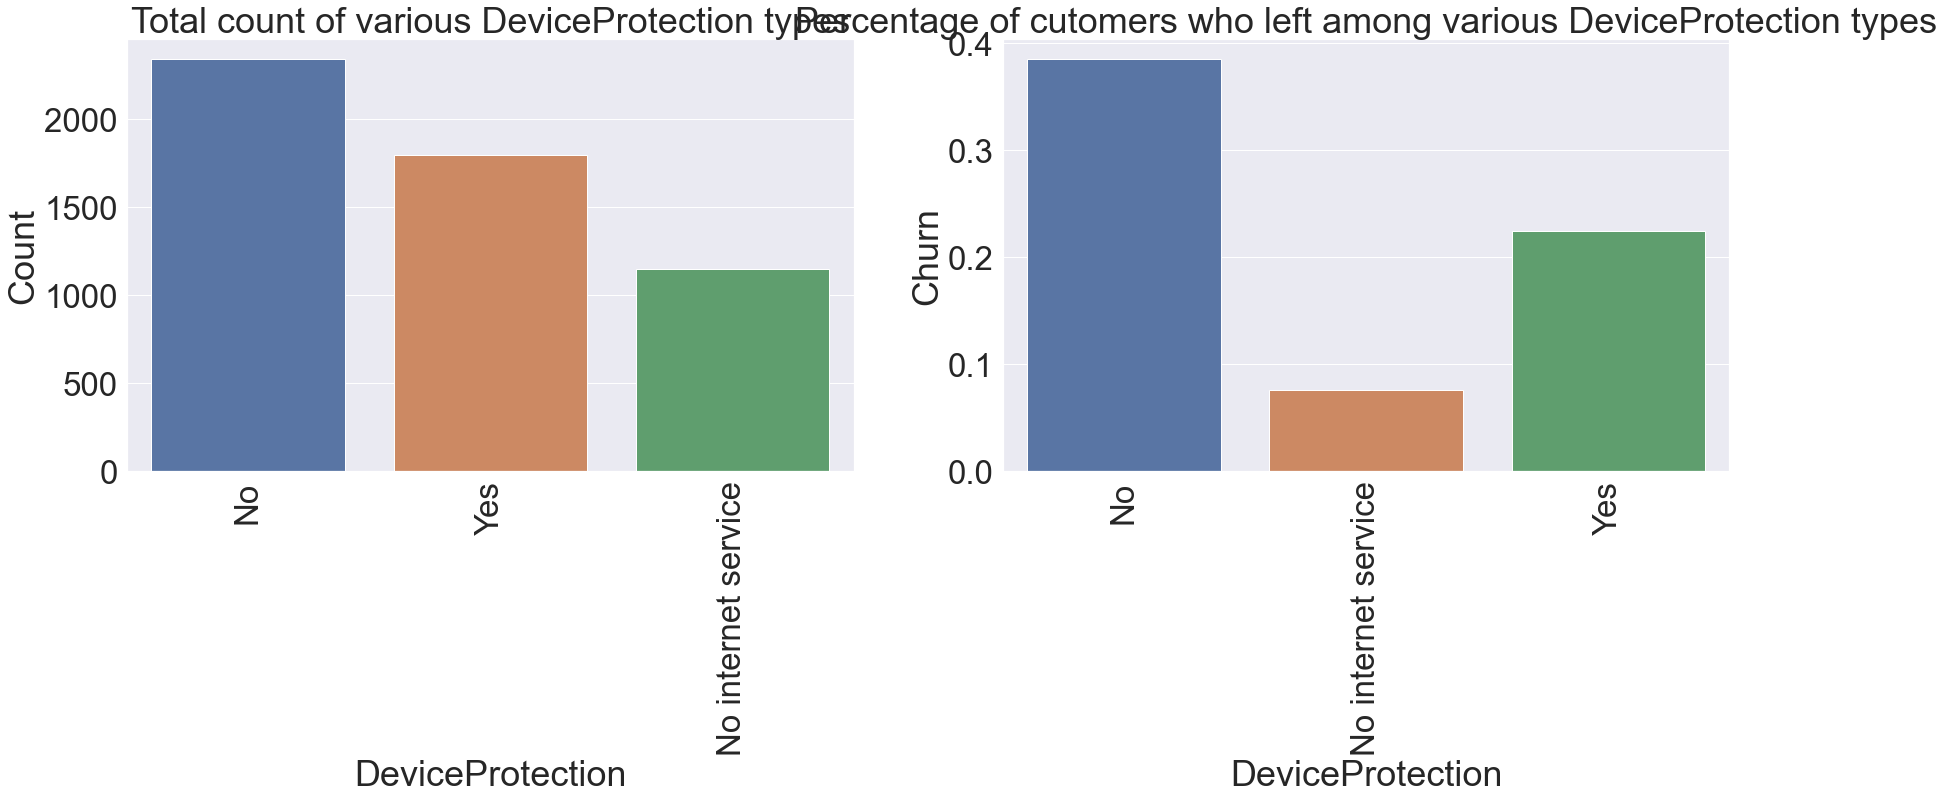

In [82]:
plot_categoric_target_map(col="OnlineBackup",target_col="Churn")
plot_categoric_target_map(col="OnlineSecurity",target_col="Churn")
plot_categoric_target_map(col="DeviceProtection",target_col="Churn")

**TechSupport, StreamingTv, Streaming Movies**

* Techsupport: wheather customr subscribed for tech support or not
* streamingTV : Whether the customer has streaming TV or not (Yes, No, No internet service) (categorical)
* streamingMovies : Whether the customer has streaming movies or not (Yes, No, No internet service)(categorical)

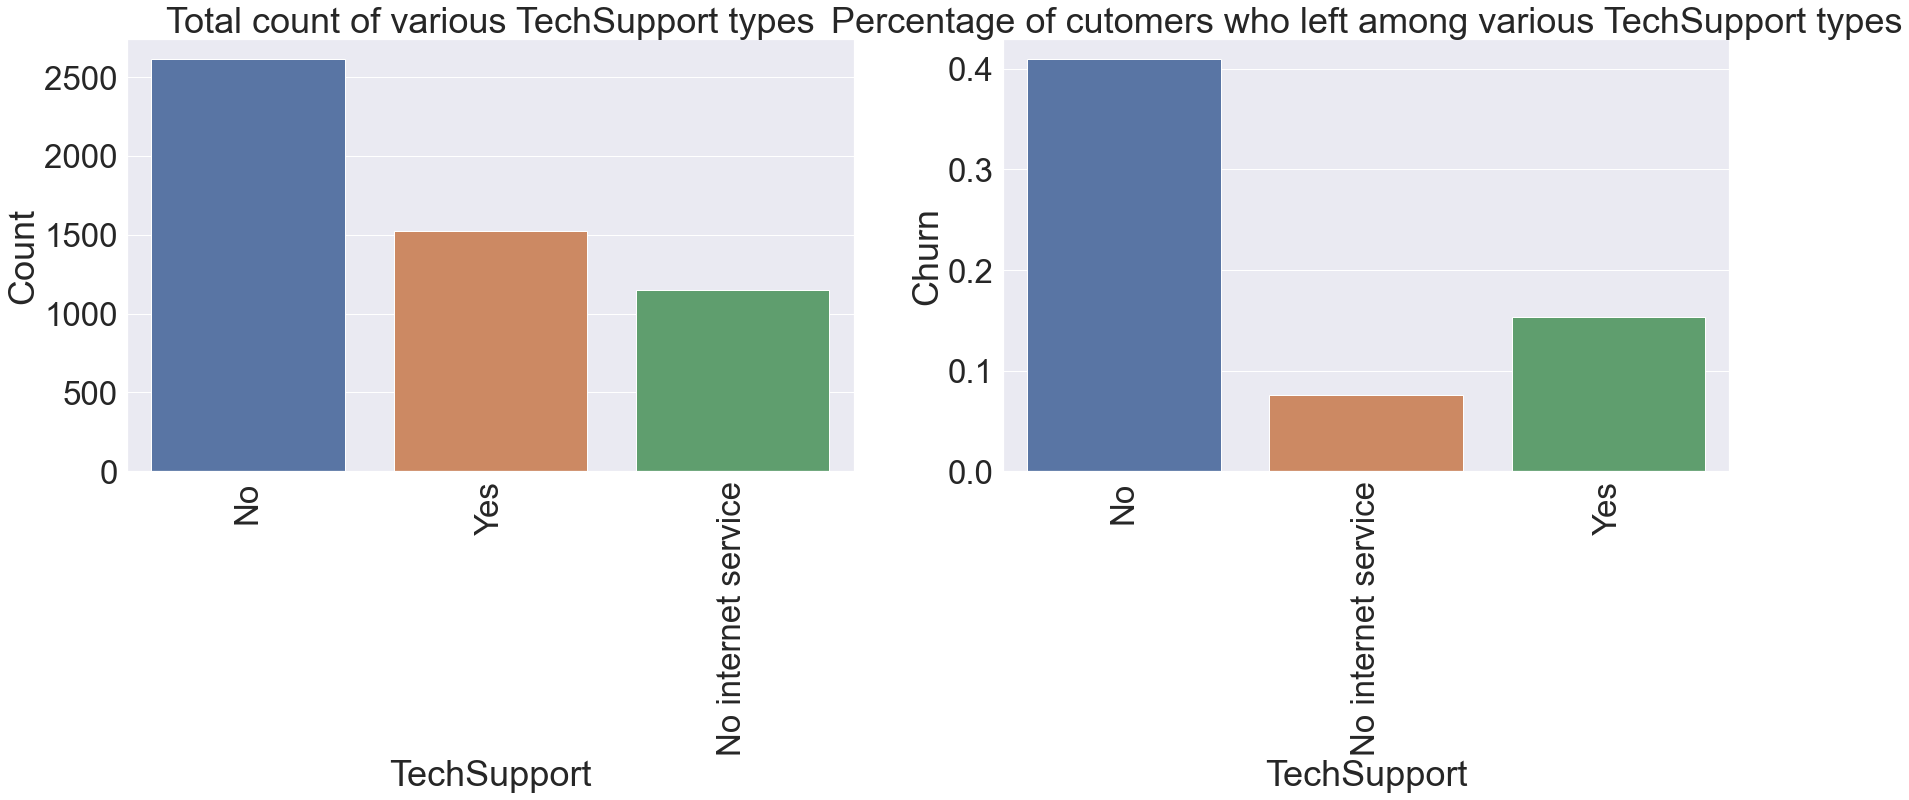

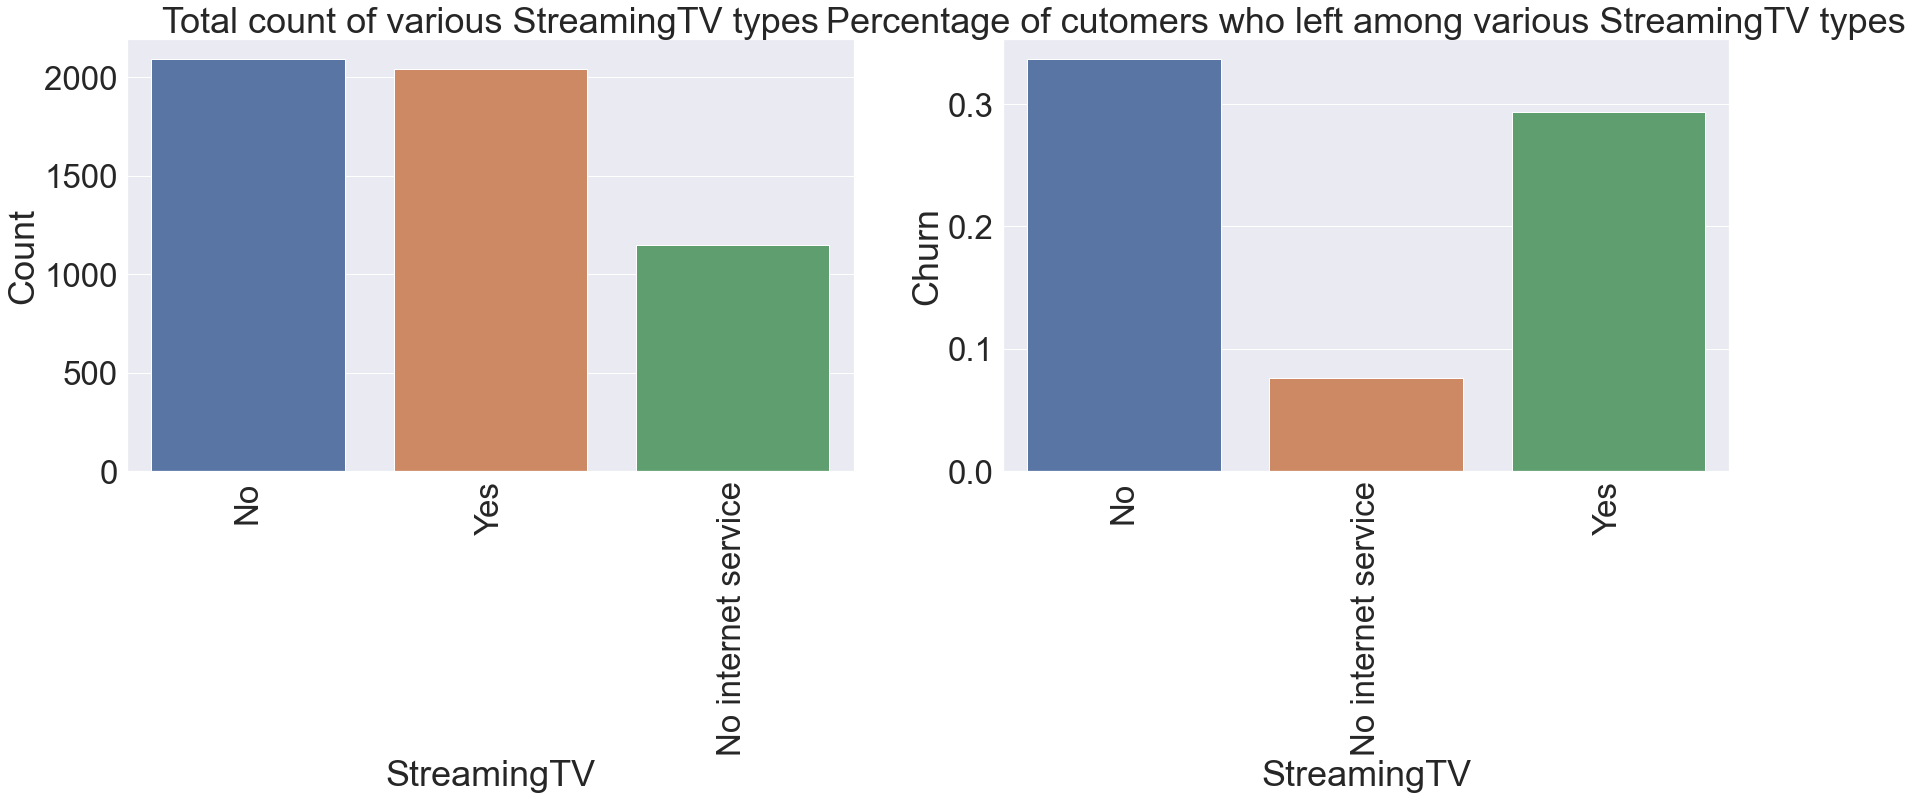

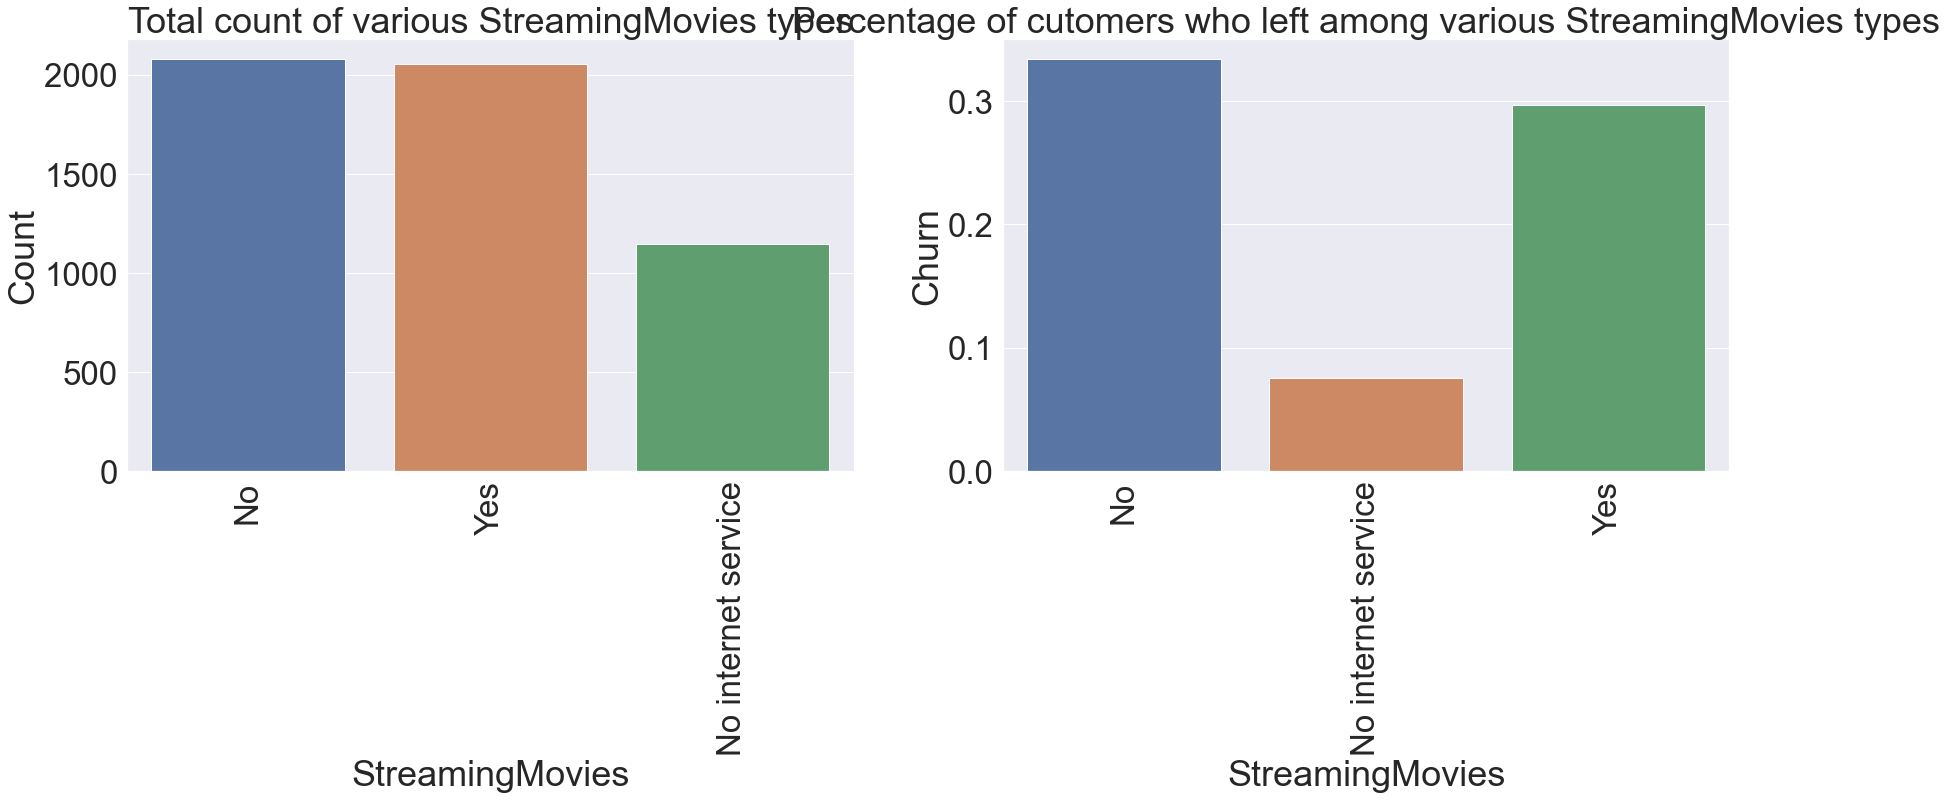

In [91]:
plot_categoric_target_map(col="TechSupport",target_col="Churn")
plot_categoric_target_map(col="StreamingTV",target_col="Churn")
plot_categoric_target_map(col="StreamingMovies",target_col="Churn")

**Contract, PapperBilling, PaymentMethod**

* Contract: Contract term of cutomer
* PaperlessBilling: Wheather the customer has papperless billing or not
* Paymentmethod: Method of payment

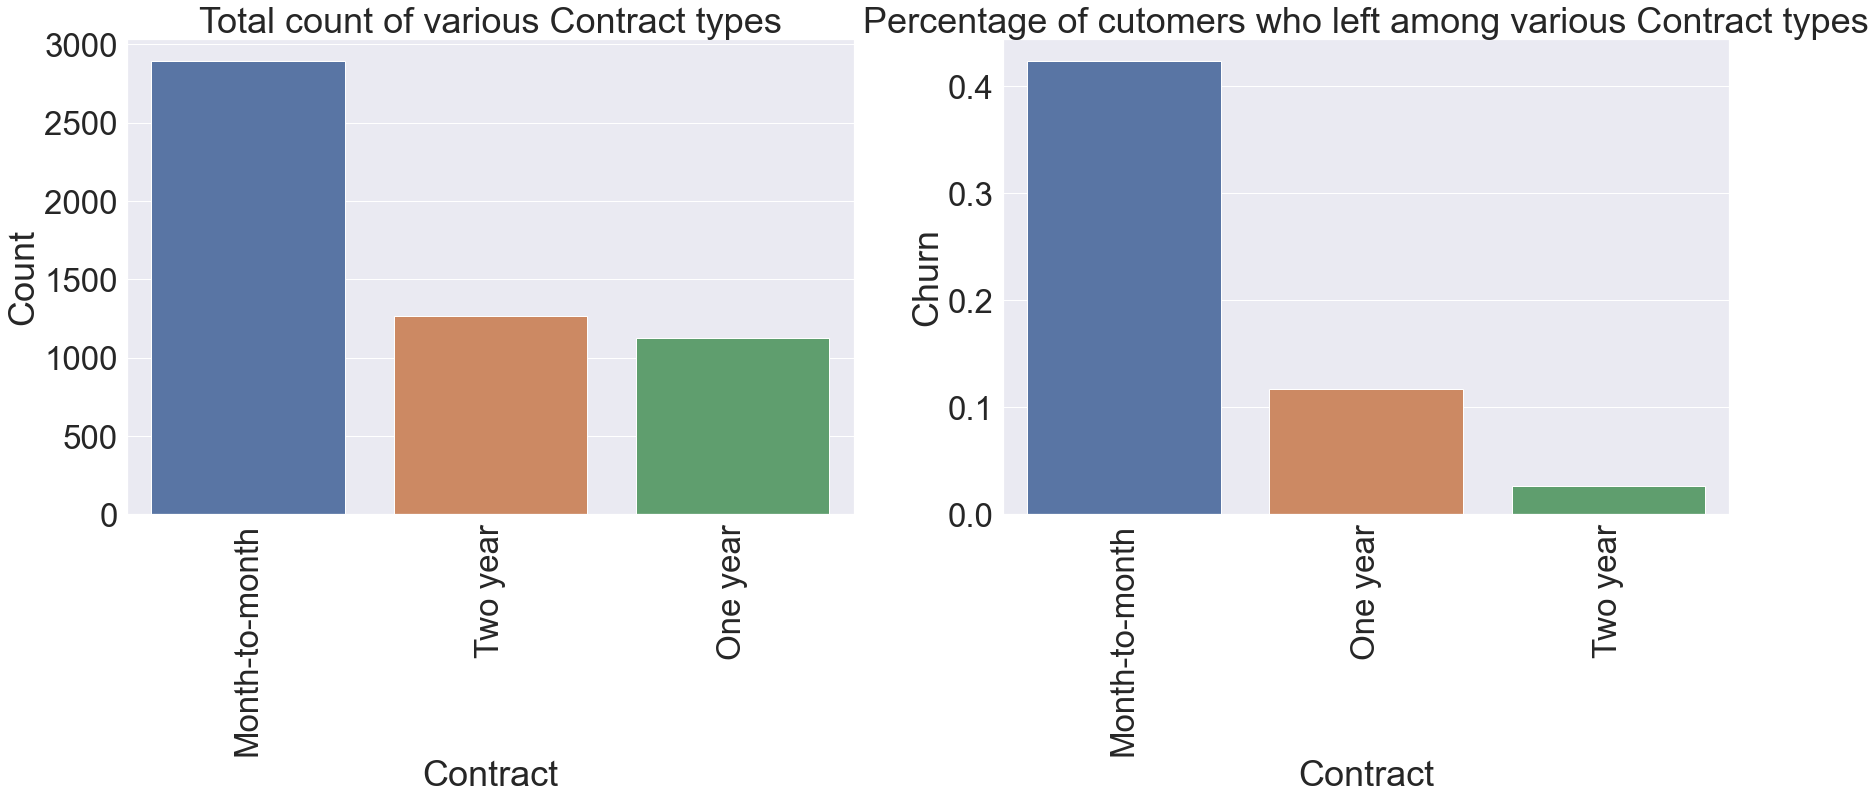

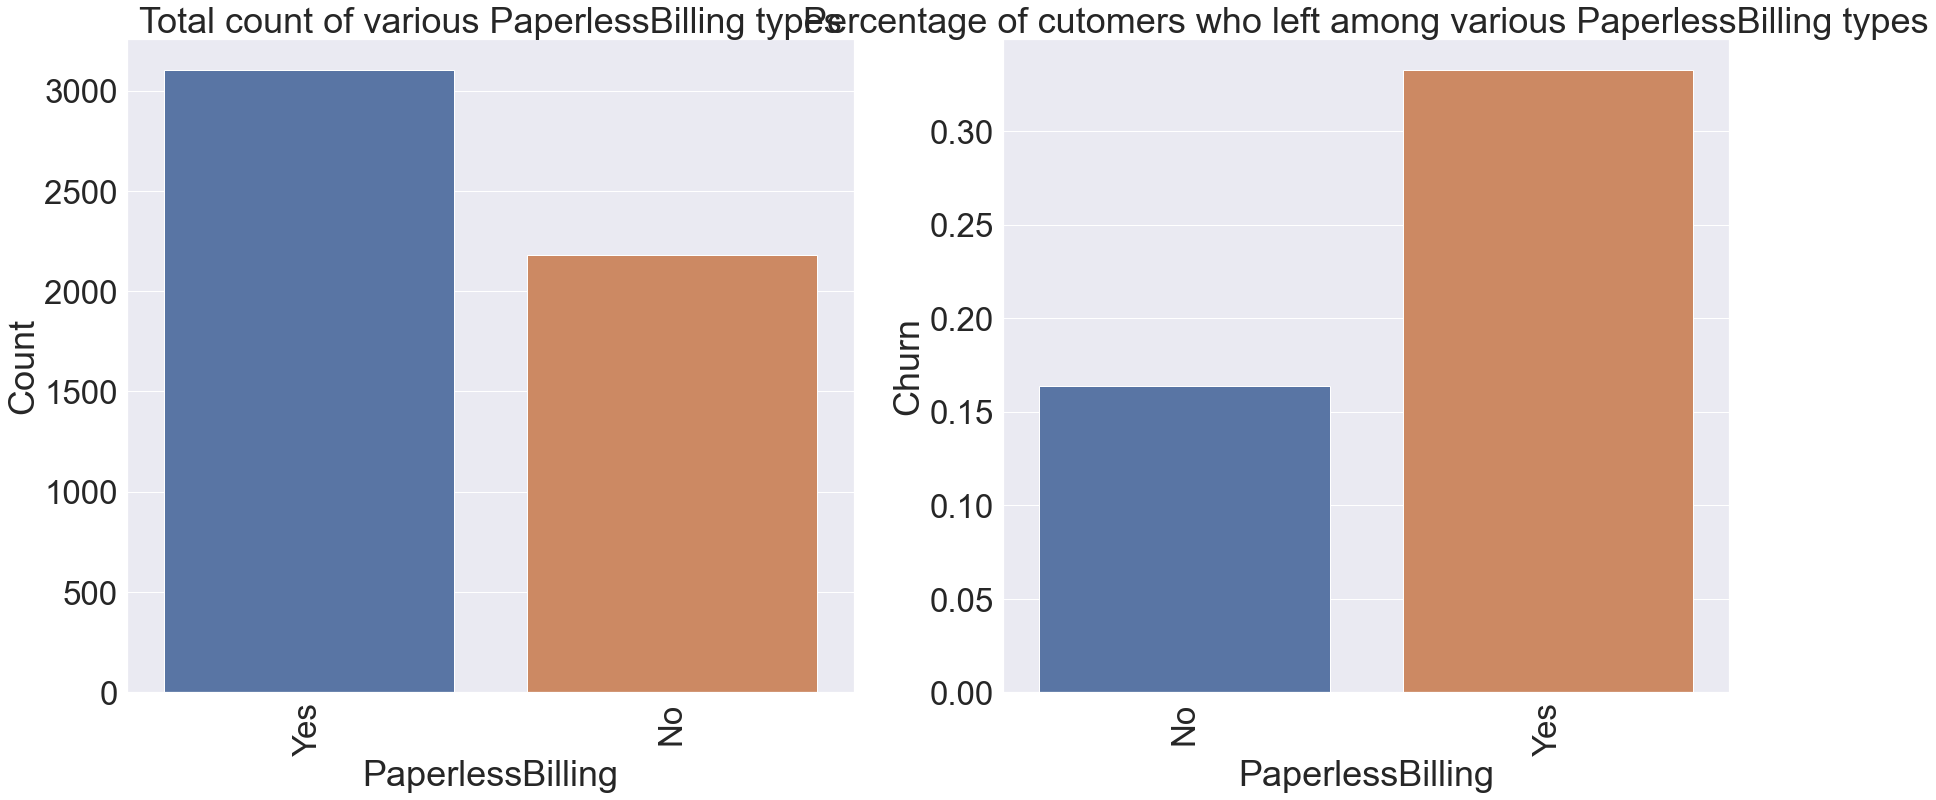

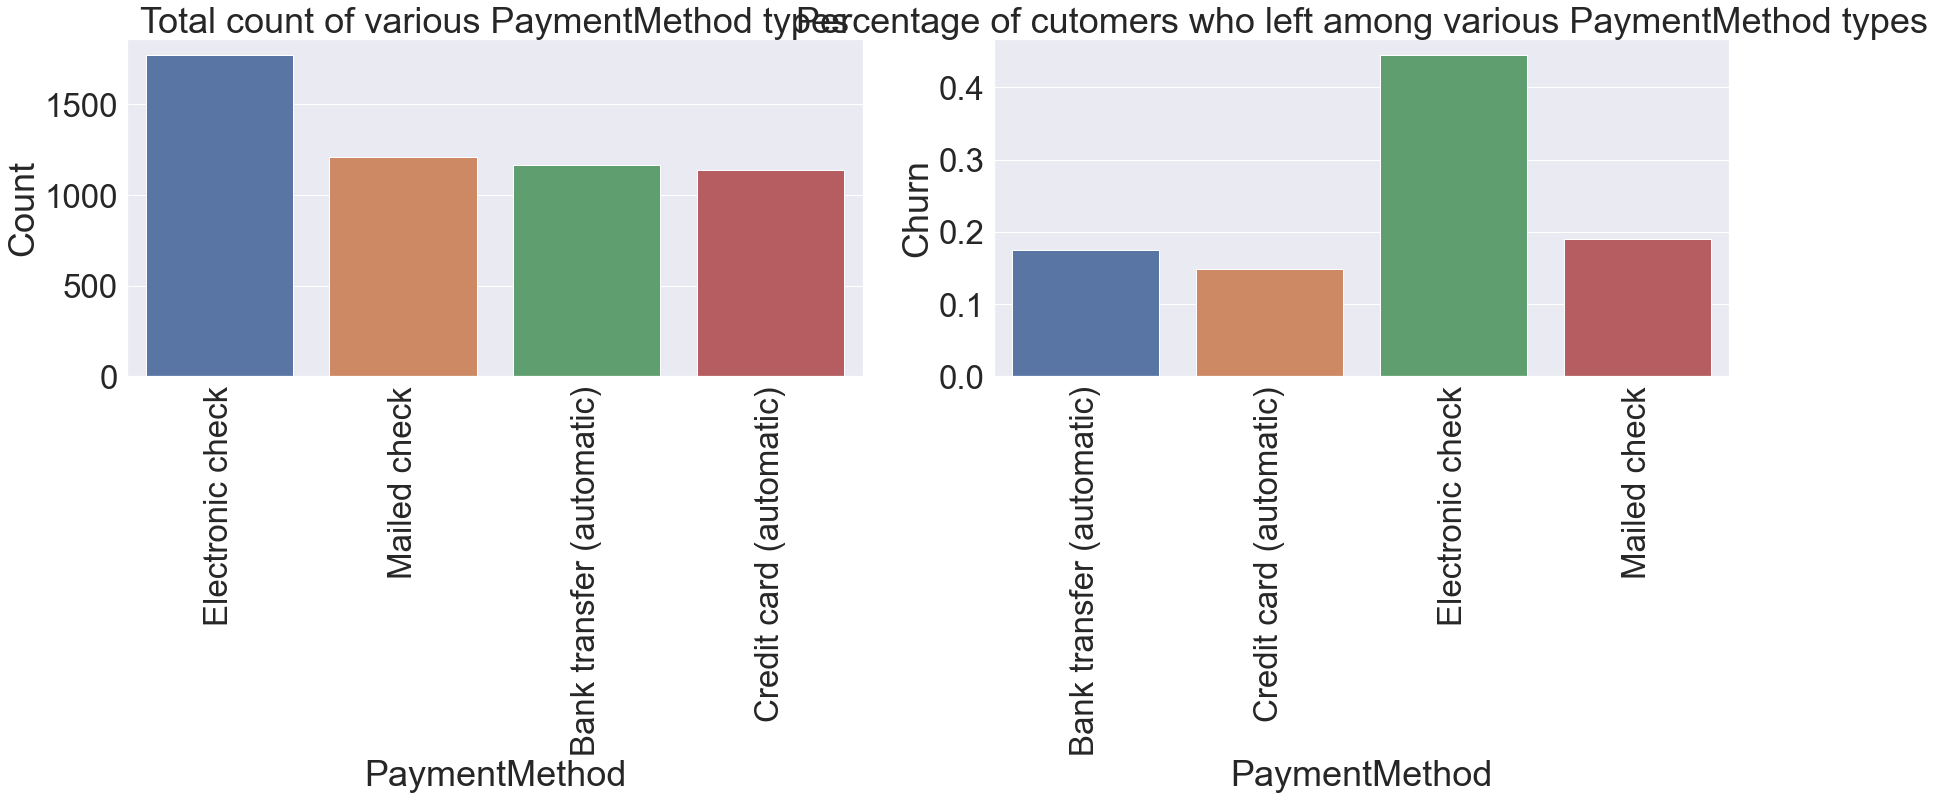

In [94]:
plot_categoric_target_map(col="Contract",target_col="Churn")
plot_categoric_target_map(col="PaperlessBilling",target_col="Churn")
plot_categoric_target_map(col="PaymentMethod",target_col="Churn")

**MonthlyCharges and TotalCharges**

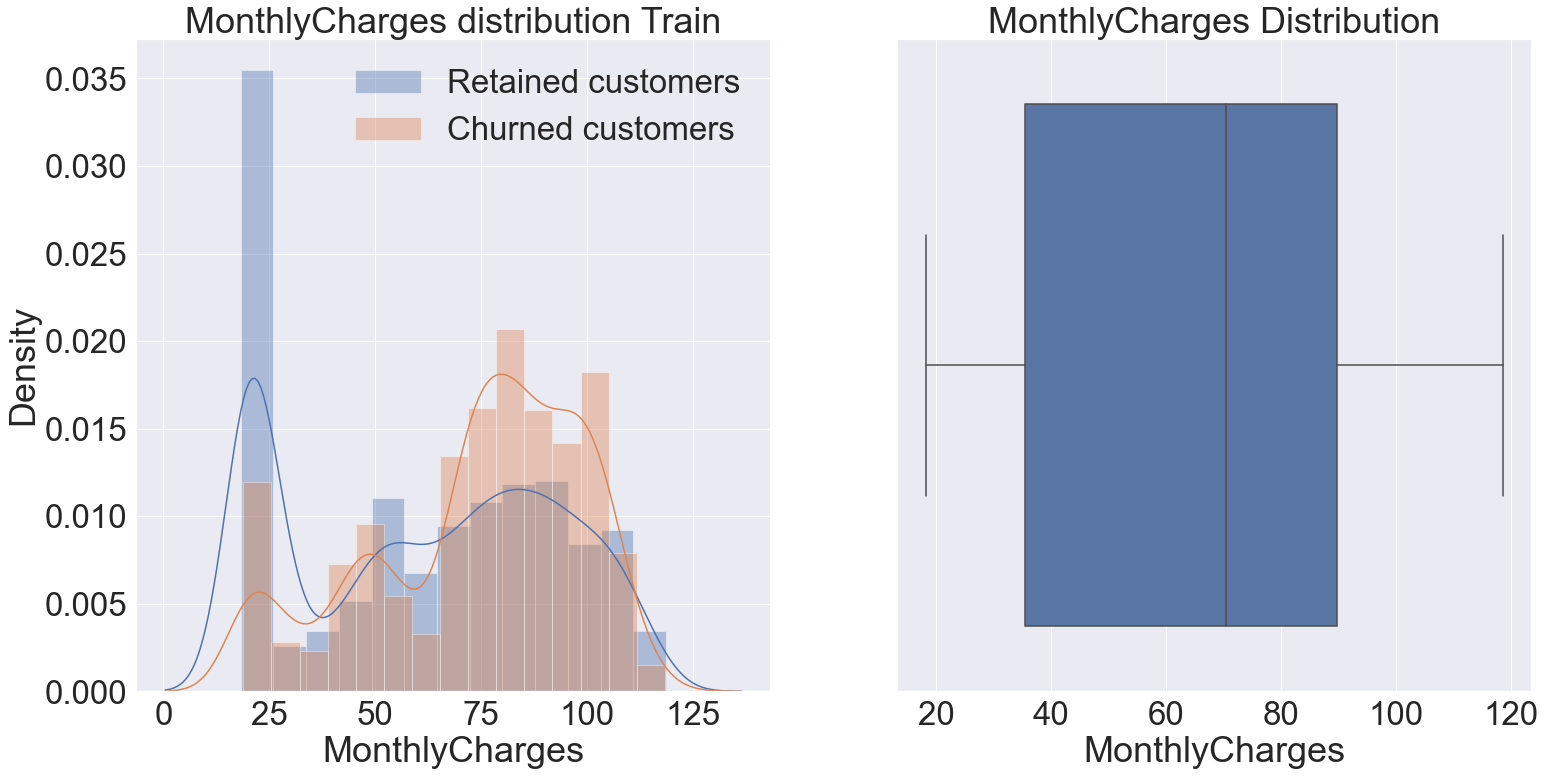

In [98]:
plot_numeric_target_map(col_name="MonthlyCharges",target_col="Churn")


In [108]:
# there are certain columns which are  ' ' in total charges column 

df_train['TotalCharges'] = df_train['TotalCharges'].apply(lambda x: -1 if x == ' ' else float(x))
df_train['TotalCharges'] = df_train['TotalCharges'].replace(-1,df_train['TotalCharges'].mean())

df_test['TotalCharges'] = df_test['TotalCharges'].apply(lambda x: -1 if x == ' ' else float(x))
df_test['TotalCharges'] = df_test['TotalCharges'].replace(-1,df_train['TotalCharges'].mean())


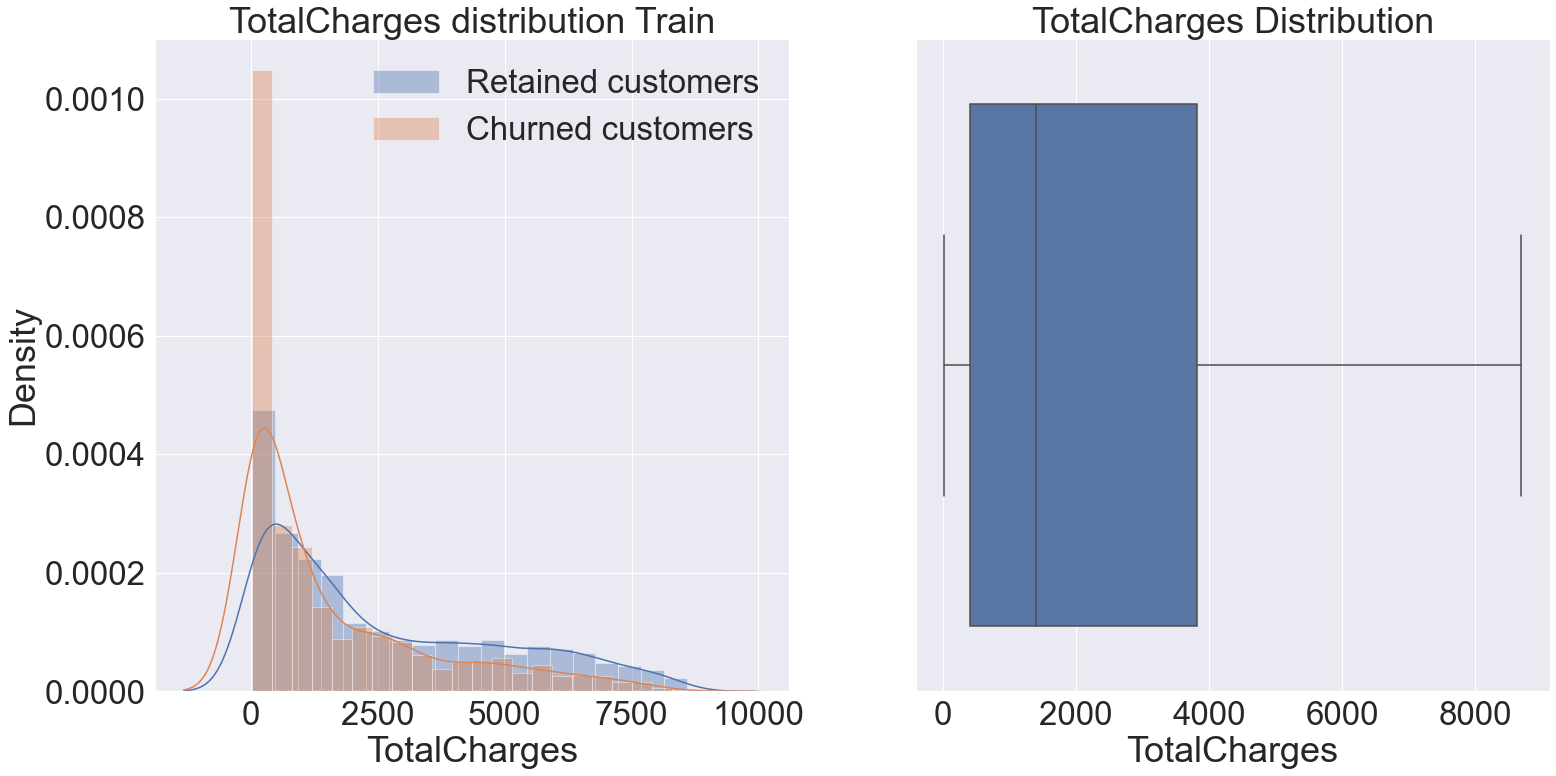

In [109]:
plot_numeric_target_map(col_name="TotalCharges",target_col="Churn")
